# Is Blue redder than Red?
<sup>By [Ramin Madarshahian](https://www.linkedin.com/in/madarshahian/)
</sup>

It is an article which compares rate of covid 19 in counties which vote for democratic party versus those voted for republican party in presidential election of 2016. The [article](#https://www.nytimes.com/2020/05/25/us/politics/coronavirus-red-blue-states.html) says "The Coronavirus Is Deadliest Where Democrats Live".
In this work I want to make this comparison by help of Bayesian inference. 
## Data:
- 2016 election results at the county-level compiled by GitHub user @tonmcg and he mentioned [Townhall.com](#https://townhall.com/election/2016/president/) as the reference.
- The source of data for coronavirus cases is [The Center for Systems Science and Engineering (CSSE) at JHU](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports).
- Counties population data are downloaded from [Data USA](https://datausa.io/) website.

## Data preparation:
In the first part of this work I calculated corona cases rate, by rate I mean comparing to population, for the US. In the second part I did the same study for states which contain both counties voted for Clinton and Trump.


In [1]:
import numpy as np
import pandas as pd
import theano as th
import pymc3 as pm
import matplotlib.pyplot as plt
#%%
Election_data = pd.read_csv(r'C:\Users\madar\Desktop\Election and corona\2016_US_County_Level_Presidential_Results.csv')
counties_population = pd.read_csv(r'C:\Users\madar\Desktop\Election and corona\counties_population.csv')
Election_data = Election_data.drop(columns=['Unnamed: 0'])
Election_data.drop_duplicates()
fib=[]
for i in counties_population['ID Geography'].values:
    fib.append(int(i[-5:]))
counties_population['ID Geography'] = fib

In [2]:
from datetime import date,timedelta
last_updated_date = date.today()
delta = timedelta(days=1)
import requests
base_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
url = base_url+last_updated_date.strftime("%m-%d-%Y")+'.csv'
while requests.get(url).status_code==404:
    last_updated_date-=delta
    url = base_url+last_updated_date.strftime("%m-%d-%Y")+'.csv'
print("last updated file found in %s"%last_updated_date)
    
df = pd.read_csv(url,index_col=0,parse_dates=[0])
df_usa_raw = df[df["Country_Region"]=="US"].dropna()
df_usa_raw_FIBS = df_usa_raw.index.values
for i in range(len(df_usa_raw_FIBS)):
    if not np.isnan(df_usa_raw_FIBS[i]):
        df_usa_raw_FIBS[i] = int(df_usa_raw_FIBS[i])
df_usa_raw['FIBS'] = df_usa_raw_FIBS
merged_data_ = Election_data.merge(df_usa_raw, how='inner', left_on='combined_fips', right_on='FIBS')
merged_data = merged_data_.merge(counties_population, how='inner', left_on='combined_fips', right_on='ID Geography')
#%%
data_final = merged_data[['votes_dem', 'votes_gop', 'Population (2018)','state_abbr', 'Province_State','county_name','Confirmed', 'Deaths','Active']]
data_final['diff'] = (data_final['votes_dem']-data_final['votes_gop']).values
data_final['sign'] = data_final['diff'].apply(func = lambda x : 0 if x>0 else 1)
data_final['state_code']=pd.factorize(data_final['state_abbr'] )[0]
#%%
data_final = data_final.dropna()

last updated file found in 2020-06-11


C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [3]:
Y_c_US = th.shared(data_final['Confirmed'].values)
Y_d_US = th.shared(data_final['Deaths'].values)
indc_US = th.shared(data_final['sign'].values)
Y_total_US = th.shared(data_final['Population (2018)'].values)

In [4]:
#%%
with pm.Model() as model_US:    
    theta  =  pm.Beta('theta', alpha=1, beta=3, shape=2)
    p = pm.Binomial('obs', p=theta[indc_US], observed=Y_c_US, n=Y_total_US)
    trace_1 = pm.sample(1000, tune=4000,cores=1,chains=2,
                   nuts_kwargs={"target_accept":0.96,
                                "max_treedepth": 12})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 5000/5000 [00:54<00:00, 92.48it/s]


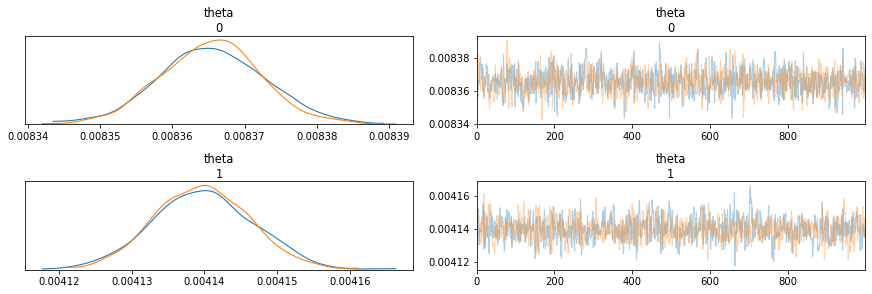

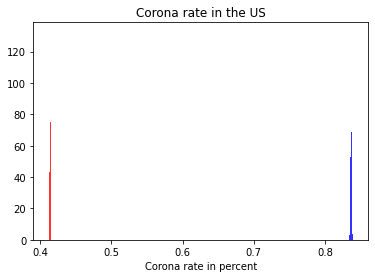

In [18]:
#%%
import arviz as az
az.plot_trace(trace_1)
plt.figure()
plt.hist(100*trace_1['theta'][:,0],50,alpha=.8,color='b');#dem
plt.hist(100*trace_1['theta'][:,1],50,alpha=.8,color='r');#gop
plt.xlabel("Corona rate in percent")
plt.title("Corona rate in the US");

In [6]:
#%%
data_final = data_final.dropna()
counter = 0
for i in range(51):
    w = data_final[data_final['state_code']==i]['sign']
    if sum(w) == len(w) or sum(w) == 0:
        print(f"All counties, which we have their data, in {data_final[data_final['state_code']==i]['state_abbr'].values[0]} voted for one party")
        data_final=data_final.drop(index=data_final[data_final['state_code']==i].index)
        counter+=1
#%%
        
data_final['state_code']=pd.factorize(data_final['state_abbr'] )[0]

Y_c = th.shared(data_final['Confirmed'].values)
Y_d = th.shared(data_final['Deaths'].values)
indc = th.shared(data_final['sign'].values)
state = th.shared(data_final['state_code'].values)
Y_total = th.shared(data_final['Population (2018)'].values)

All counties, which we have their data, in AK voted for one party
All counties, which we have their data, in DC voted for one party
All counties, which we have their data, in HI voted for one party
All counties, which we have their data, in ID voted for one party
All counties, which we have their data, in MA voted for one party
All counties, which we have their data, in ND voted for one party
All counties, which we have their data, in NV voted for one party
All counties, which we have their data, in OK voted for one party
All counties, which we have their data, in SD voted for one party
All counties, which we have their data, in VT voted for one party
All counties, which we have their data, in WV voted for one party
All counties, which we have their data, in WY voted for one party


In [7]:
#%%
with pm.Model() as model_state_wise:    
    theta  =  pm.Beta('theta', alpha=1, beta=3, shape=(51-counter,2))
    p = pm.Binomial('obs', p=theta[state,indc], observed=Y_c, n=Y_total)
    trace = pm.sample(1000, tune=4000,cores=1,chains=2,
                   nuts_kwargs={"target_accept":0.96,
                                "max_treedepth": 12})

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|██████████████████████████

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


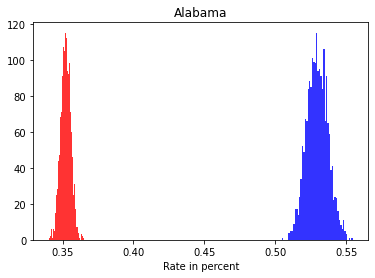

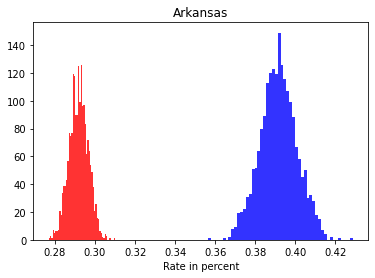

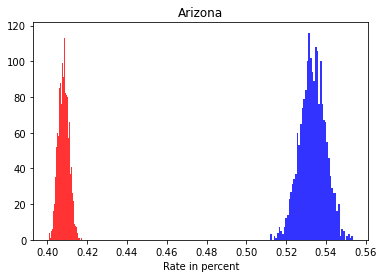

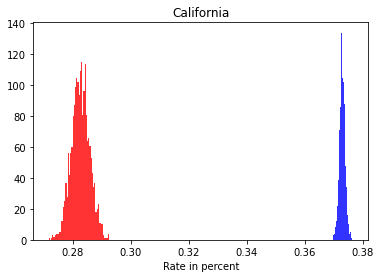

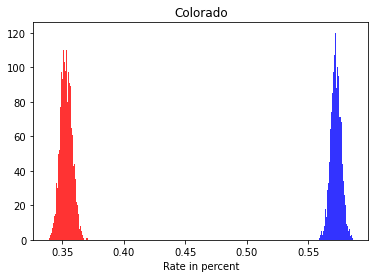

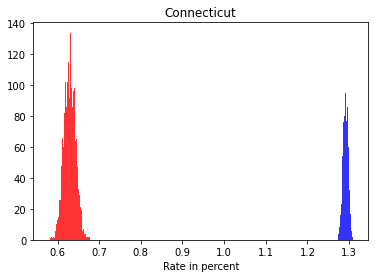

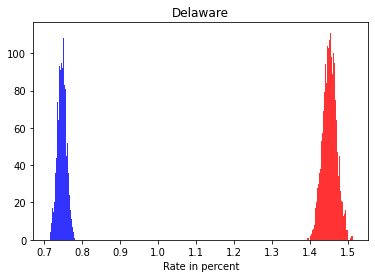

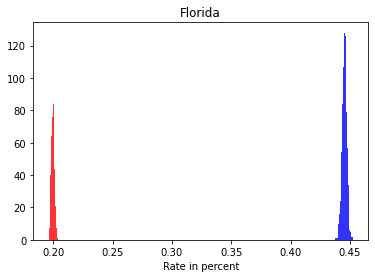

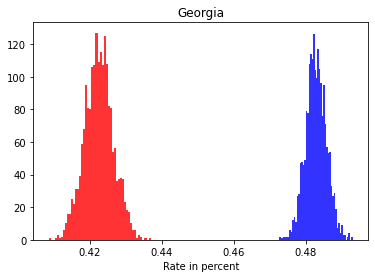

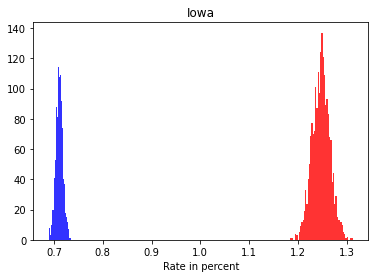

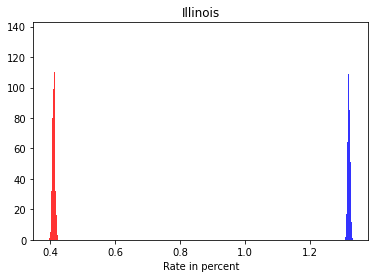

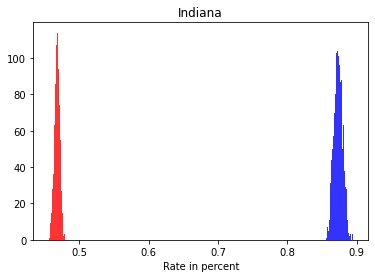

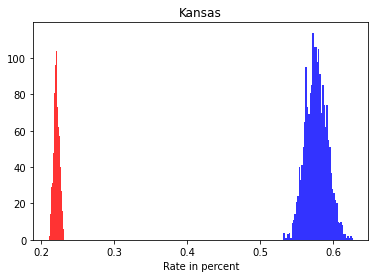

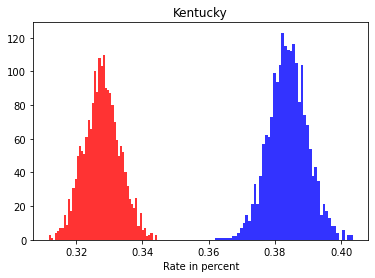

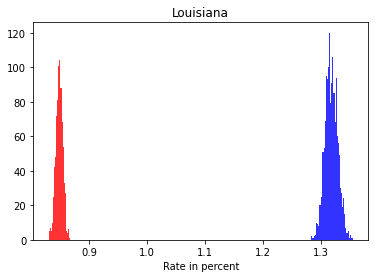

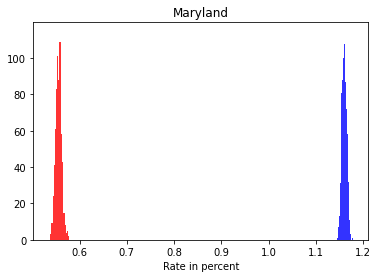

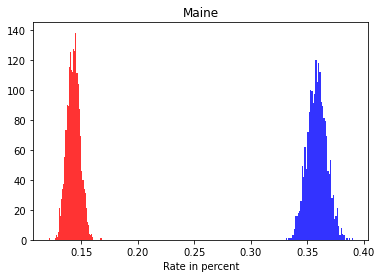

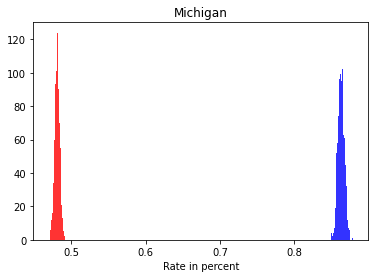

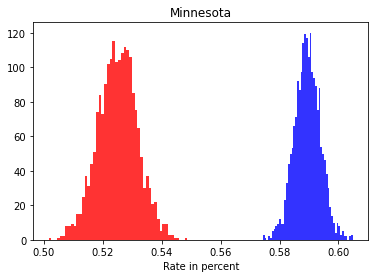

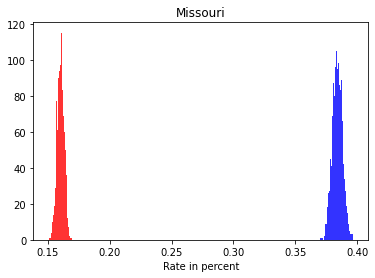

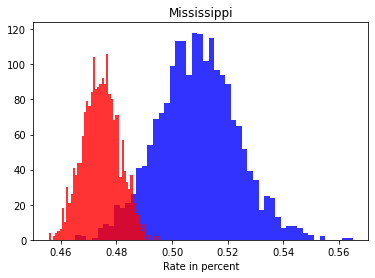

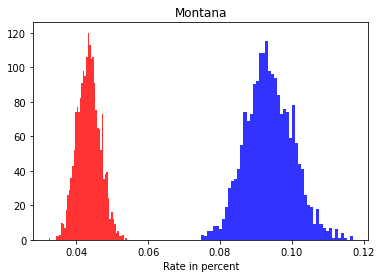

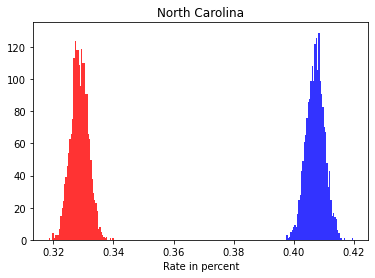

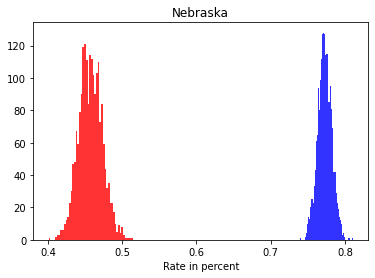

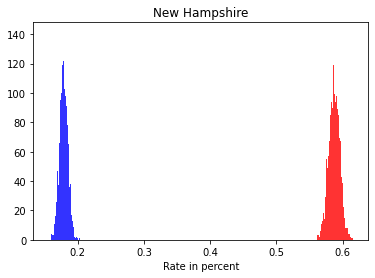

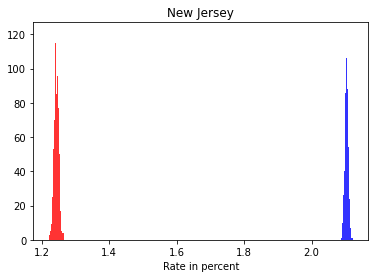

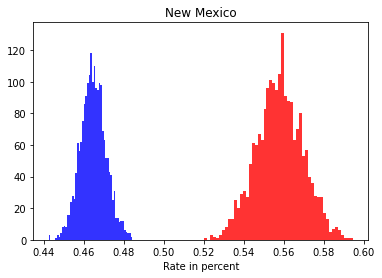

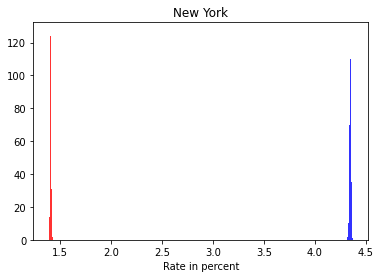

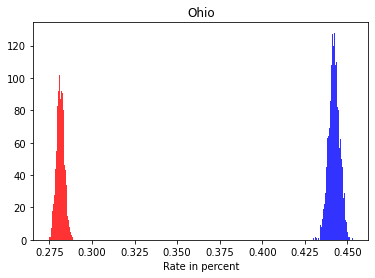

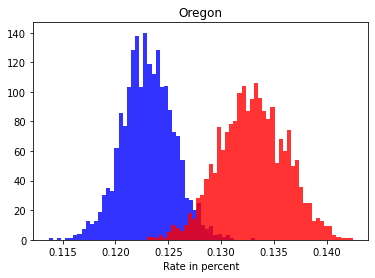

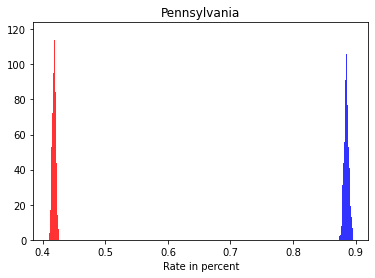

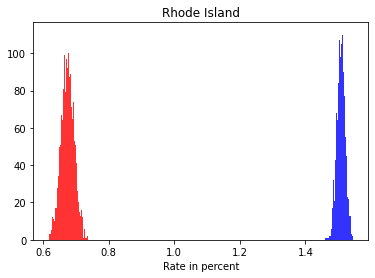

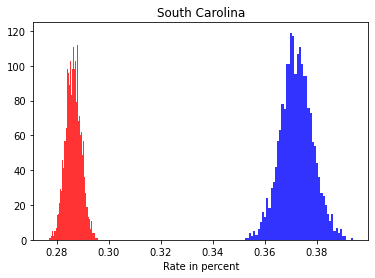

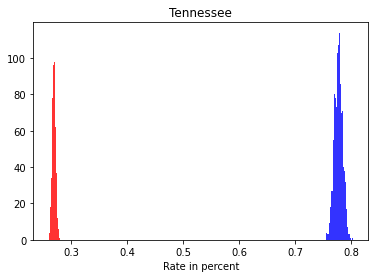

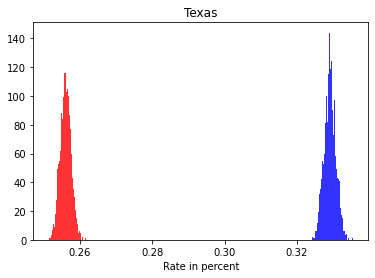

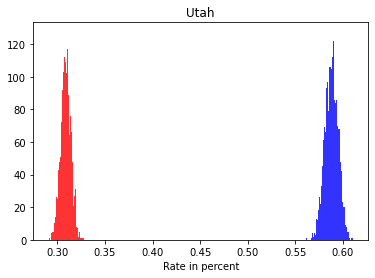

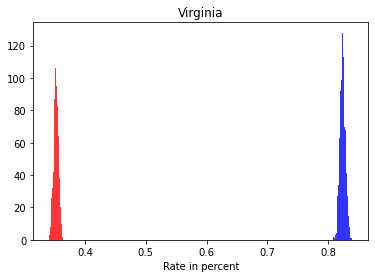

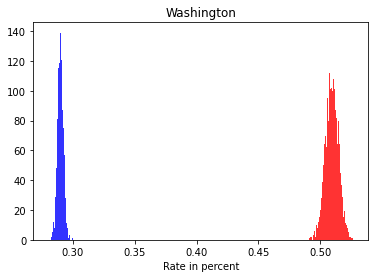

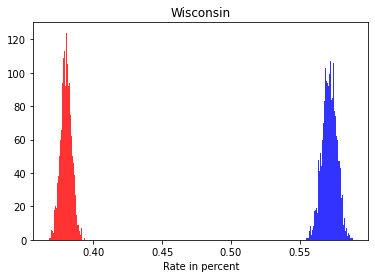

In [8]:
#%%
for i in range(51-counter):
    plt.figure()
    plt.hist(100*trace['theta'][:,i,0],50,alpha=.8,color='b')#dem
    plt.hist(100*trace['theta'][:,i,1],50,alpha=.8,color='r')#gop
    plt.xlabel("Rate in percent")
    plt.title(pd.factorize(data_final['Province_State'] )[1][i])

## Mortality rate
What about the mortality rate? So far I studied the rate of confirmed cases to population, what about rate of deaths to confirmed cases. Let's take a look at mortality rate in the US and also its states.
### Mortality rate in the US

In [9]:
#%%
with pm.Model() as model_mortality_US:    
    theta  =  pm.Beta('theta', alpha=1, beta=3, shape=2)
    p = pm.Binomial('obs', p=theta[indc_US], observed=Y_d_US, n=Y_c_US)
    trace_mortality_US = pm.sample(1000, tune=4000,cores=1,chains=2,
                   nuts_kwargs={"target_accept":0.96,
                                "max_treedepth": 12})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 5000/5000 [00:16<00:00, 295.30it/s]


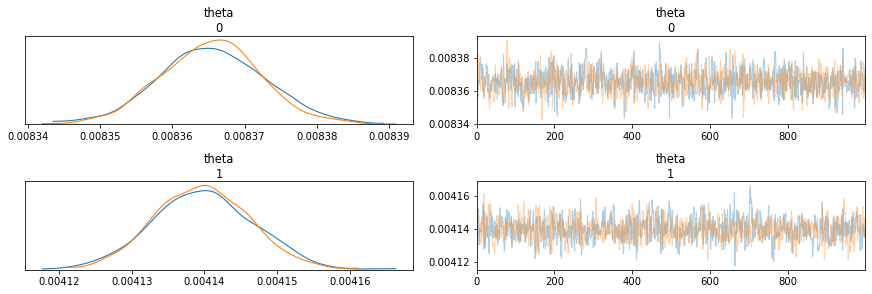

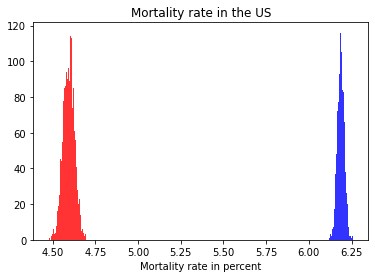

In [15]:
#%%
import arviz as az
az.plot_trace(trace_1)
plt.figure()
plt.hist(100*trace_mortality_US['theta'][:,0],50,alpha=.8,color='b');#dem
plt.hist(100*trace_mortality_US['theta'][:,1],50,alpha=.8,color='r');#gop
plt.xlabel("Mortality rate in percent")
plt.title("Mortality rate in the US");

### Mortality rate in the US's states

In [11]:
#%%
with pm.Model() as model_mortality_state_wise:    
    theta  =  pm.Beta('theta', alpha=1, beta=3, shape=(51-counter,2))
    p = pm.Binomial('obs', p=theta[state,indc], observed=Y_d, n=Y_c)
    trace_mortality_state_wise = pm.sample(1000, tune=4000,cores=1,chains=2,
                   nuts_kwargs={"target_accept":0.96,
                                "max_treedepth": 12})

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 5000/5000 [00:46<00:00, 106.94it/s]
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


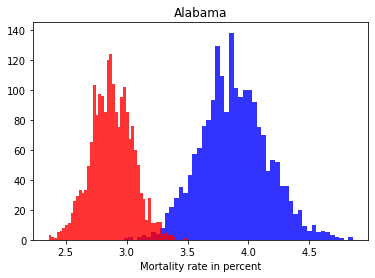

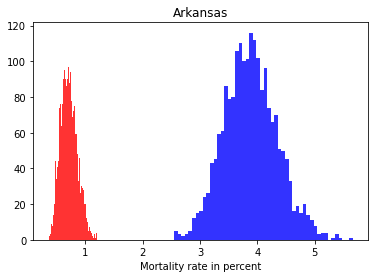

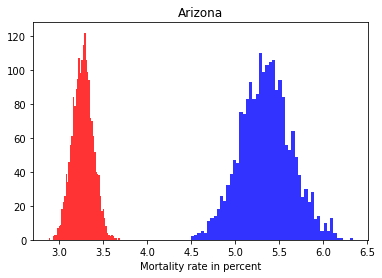

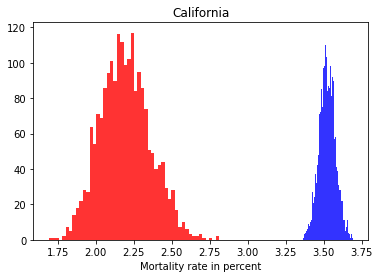

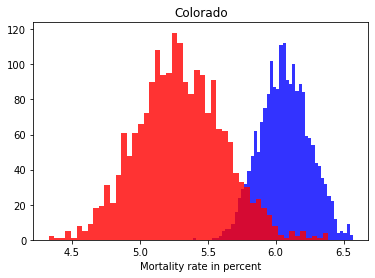

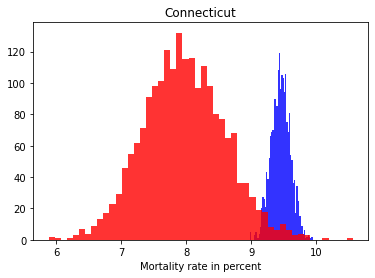

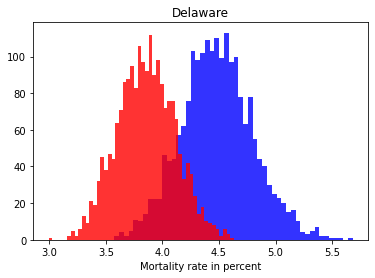

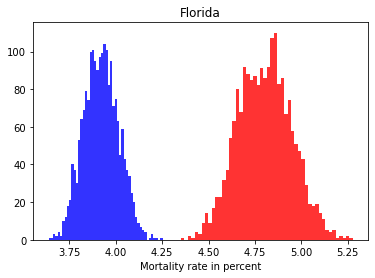

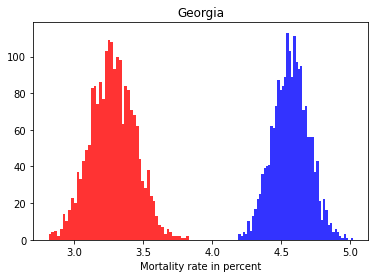

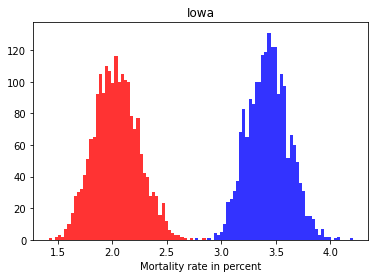

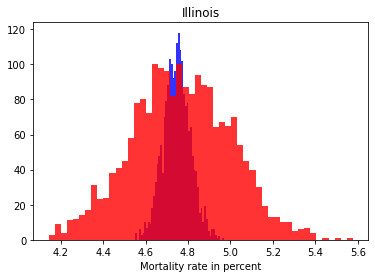

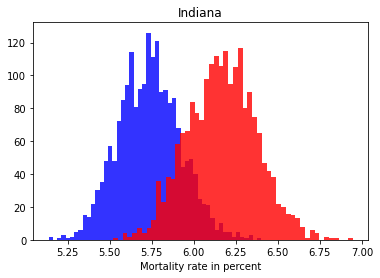

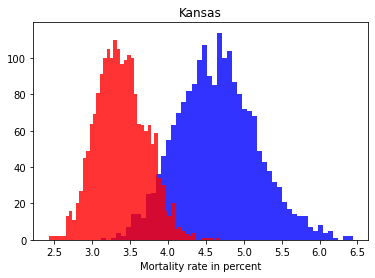

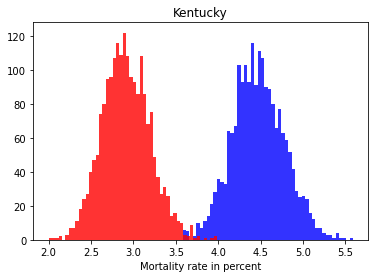

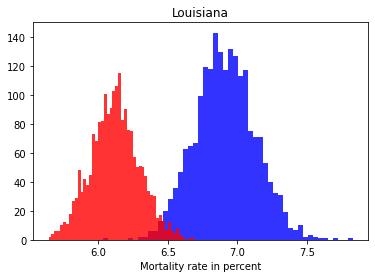

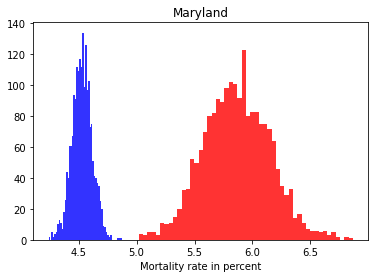

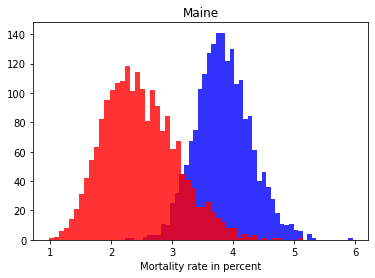

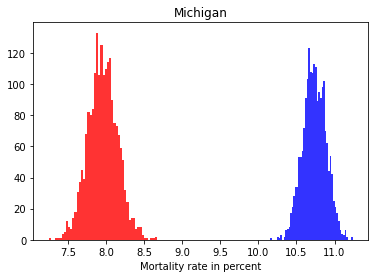

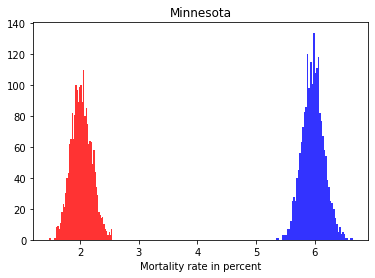

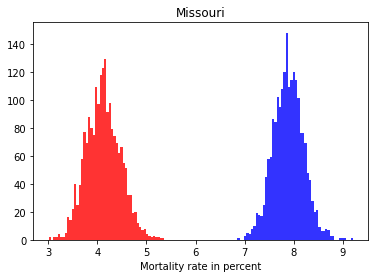

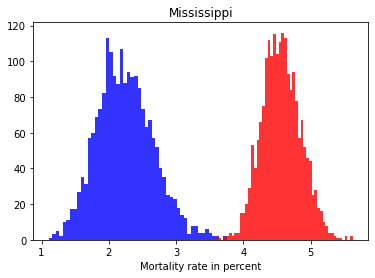

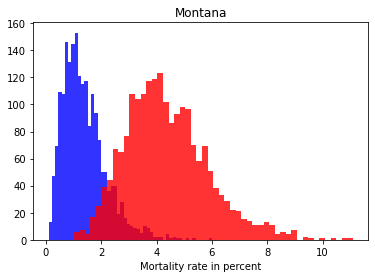

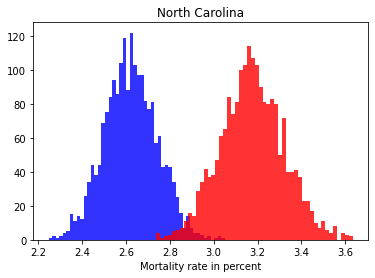

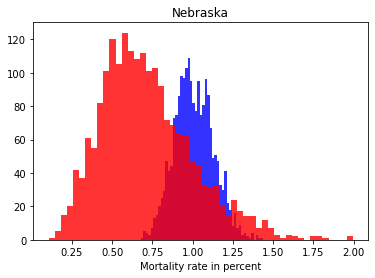

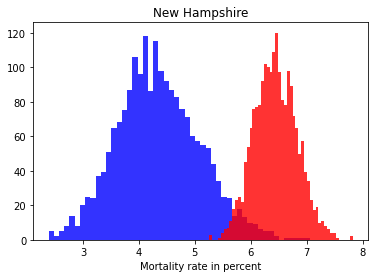

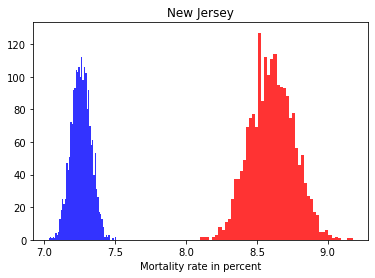

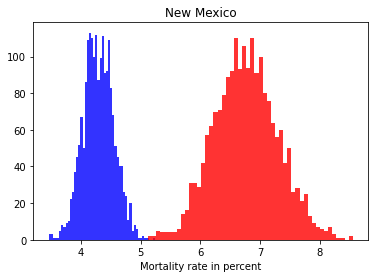

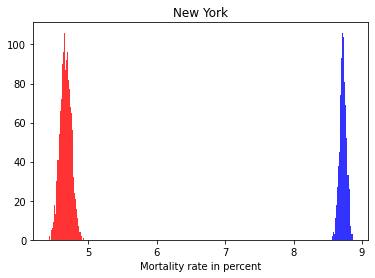

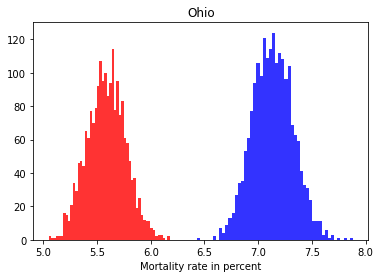

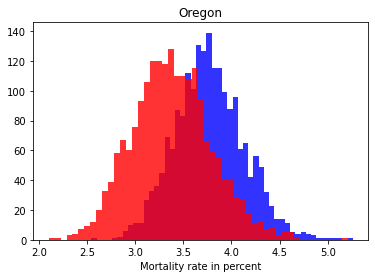

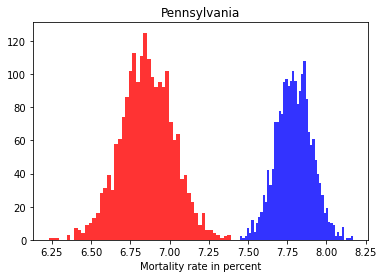

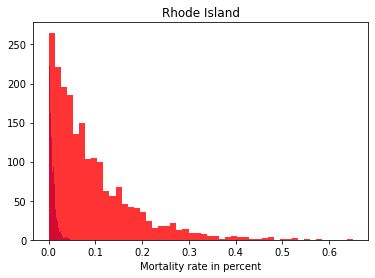

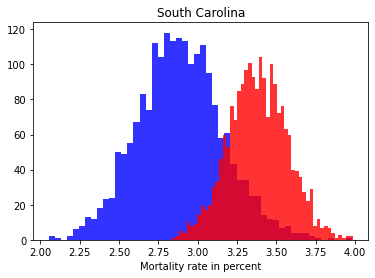

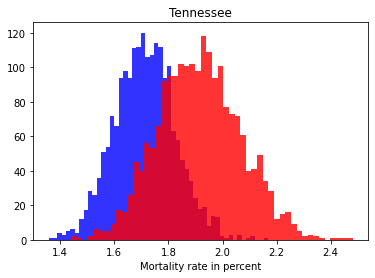

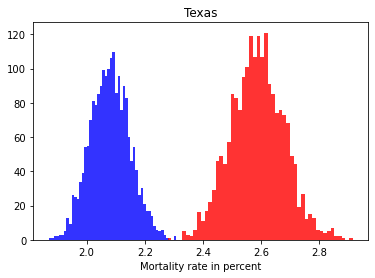

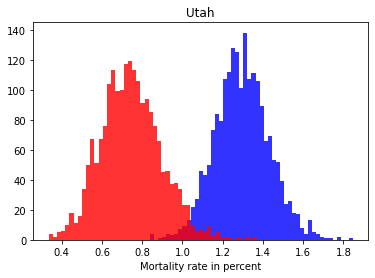

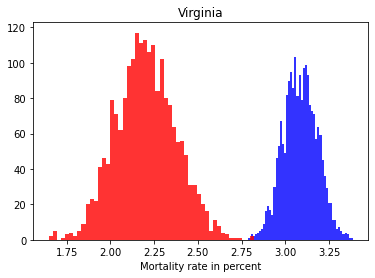

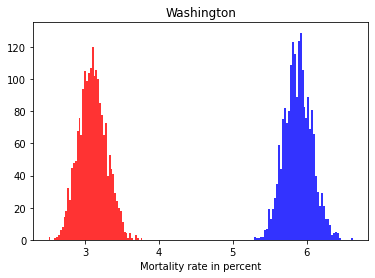

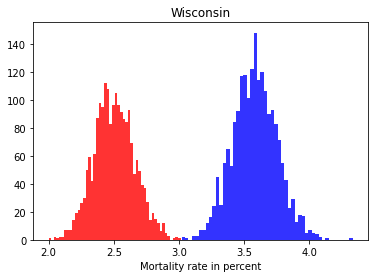

In [16]:
#%%
state_ =pd.factorize(data_final['Province_State'] )[1]
for i in range(51-counter):
    plt.figure()
    plt.hist(100*trace_mortality_state_wise['theta'][:,i,0],50,alpha=.8,color='b');#dem
    plt.hist(100*trace_mortality_state_wise['theta'][:,i,1],50,alpha=.8,color='r');#gop
    plt.xlabel("Mortality rate in percent")
    plt.title(state_[i])

## concluding remark
Aparently rate of confirmed cases for coronavirus to population and also mortality rate is higher for counties who voted for democratic parties. It would be interesting to study its reason. I could be different poverty rate, life style or density of population in each counties or any other factors. I believe it worse to study and find this hidden variable. 